In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import math
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import requests
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_palette("GnBu_d")
sns.set_style('whitegrid')
%matplotlib inline

#Loading our data

In [3]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [5]:
df =  pd.read_csv("car_data_for_price_estimation.csv")
df.head(10)

,make_id,model_id,submodel_id,price,mileage,country_code,year,currency,updated_at
0,86,912.0,957.0,2150000,30000,PK,2017,PKR,2019-07-25 21:50:04.860913+00
1,73,774.0,599.0,119000,28800,AE,2013,AED,2019-12-27 22:50:07.718331+00
2,86,935.0,NaN,2750000,1,PK,2020,PKR,2020-12-02 22:49:39.536877+00
3,5,41.0,NaN,179000,93000,ZA,2012,ZAR,2020-02-16 22:50:05.555076+00
4,22,222.0,NaN,108000,48767,AE,2016,AED,2020-10-04 21:50:10.793611+00
5,86,1036.0,NaN,2500000,146000,PK,2008,PKR,2021-02-05 22:50:17.448336+00
6,8,75.0,NaN,409900,39000,ZA,2018,ZAR,2021-01-31 03:07:25.513245+00
7,86,912.0,NaN,20000,800,ZA,1988,ZAR,2019-09-08 21:50:05.766048+00
8,58,566.0,NaN,4650,59999,KW,2015,KWD,2021-05-06 21:08:37.030854+00
9,27,287.0,NaN,56500,81000,AE,2015,AED,2020-10-27 23:12:22.849894+00


#Preprocessing

### understanding the dataset

In [6]:
df.describe(include='all')

,make_id,model_id,submodel_id,price,mileage,country_code,year,currency,updated_at
count,1.048575e+06,927782.000000,171655.000000,1.048575e+06,1.048575e+06,1048575,1.048575e+06,1048575,1048575
unique,NaN,NaN,NaN,NaN,NaN,6,NaN,6,185910
top,NaN,NaN,NaN,NaN,NaN,ZA,NaN,ZAR,2019-10-16 21:50:05.318881+00
freq,NaN,NaN,NaN,NaN,NaN,460906,NaN,460906,5741
mean,5.929174e+01,643.603866,719.562710,4.557117e+06,1.292933e+05,NaN,2.011227e+03,NaN,NaN
std,2.691895e+01,309.822686,288.145938,3.908113e+09,3.334412e+06,NaN,7.594775e+00,NaN,NaN
min,1.000000e+00,1.000000,6.000000,1.000000e+02,0.000000e+00,NaN,1.926000e+03,NaN,NaN
25%,3.500000e+01,342.000000,452.000000,6.500000e+04,3.500000e+04,NaN,2.007000e+03,NaN,NaN
50%,6.600000e+01,697.000000,779.000000,1.800000e+05,8.500000e+04,NaN,2.013000e+03,NaN,NaN
75%,8.600000e+01,918.000000,961.000000,6.200000e+05,1.399990e+05,NaN,2.017000e+03,NaN,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   make_id       1048575 non-null  int64  
 1   model_id      927782 non-null   float64
 2   submodel_id   171655 non-null   float64
 3   price         1048575 non-null  int64  
 4   mileage       1048575 non-null  int64  
 5   country_code  1048575 non-null  object 
 6   year          1048575 non-null  int64  
 7   currency      1048575 non-null  object 
 8   updated_at    1048575 non-null  object 
dtypes: float64(2), int64(4), object(3)
memory usage: 72.0+ MB


In [8]:
df.isnull().sum()

make_id              0
model_id        120793
submodel_id     876920
price                0
mileage              0
country_code         0
year                 0
currency             0
updated_at           0
dtype: int64

###Dropping duplicate rows

In [9]:
df = df.drop_duplicates()

###check if coutry and currency are the same

In [10]:
different = 0
for currency, country in zip(df['currency'],df['country_code']):
  if currency[:2] != country:
    different += 1
print(different)
# k= 0 therefore no problem

0


### make sure updated_at values have the same format 


In [11]:
#we test if there is a different ending than +00
diff_format = 0

for date in enumerate(df['updated_at']):
  if date[1][len(date[1])-3:] !='+00' :
    diff_format += 1
print(diff_format)

#diff_format is 0

0


### Change update_at into datetime

In [ ]:
df['updated_at_date'] = df.apply(lambda row: datetime.strptime(row.updated_at[:-3], '%Y-%m-%d %H:%M:%S.%f'), axis = 1)

#### test if updated_at_date is less than today's date

In [ ]:
print(df['updated_at_date'].max())
#most recent date is in May 

### We fix year value if it exceeds the year of the update

In [ ]:
df['year_fixed'] = ''
i=0

for update_y,y,make in zip(df['updated_at_date'],df['year'],df['make_id']):
  i += 1
  if update_y.year < y:
    df['year_fixed'].iloc[i] = math.floor(df.groupby(['make_id'])['year'].mean()[make])
    
df['year_fixed'] = np.where(df.year_fixed == '', df.year,df.year_fixed)

#this ensures that years which exceeed last update are changed into the mean of the year for that car's model

### Adding age column

In [ ]:
df['age'] = datetime.today().year - df['year_fixed']
df['age'] = df['age'].astype('int64')
df = df.loc[df.age>=0]

### Convert prices in KWD currency
##### We convert using exchange_api to have updated values which requires an account so the values will be stores in a csv file for testing

In [ ]:
"""
#we are using real time conversion rate using ExchangeRate-API
PKR2KWD = requests.get("https://v6.exchangerate-api.com/v6/96af3980d2992c47f7a6b9fe/pair/PKR/KWD")
AED2KWD = requests.get("https://v6.exchangerate-api.com/v6/96af3980d2992c47f7a6b9fe/pair/AED/KWD")
ZAR2KWD = requests.get("https://v6.exchangerate-api.com/v6/96af3980d2992c47f7a6b9fe/pair/ZAR/KWD")
LBP2KWD = requests.get("https://v6.exchangerate-api.com/v6/96af3980d2992c47f7a6b9fe/pair/LBP/KWD")
SAR2KWD = requests.get("https://v6.exchangerate-api.com/v6/96af3980d2992c47f7a6b9fe/pair/SAR/KWD")

PKR2KWD = PKR2KWD.json()['conversion_rate']
AED2KWD = AED2KWD.json()['conversion_rate']
ZAR2KWD = ZAR2KWD.json()['conversion_rate']
LBP2KWD = LBP2KWD.json()['conversion_rate']
SAR2KWD = SAR2KWD.json()['conversion_rate']


conversion_rate = pd.DataFrame({'currency':['PKR2KWD','AED2KWD','ZAR2KWD','LBP2KWD', 'SAR2KWD'],
                         'conversion_rate':[PKR2KWD, AED2KWD, ZAR2KWD, LBP2KWD, SAR2KWD]
                         }) 
conversion_rate.to_csv('/content/drive/MyDrive/Colab Notebooks/conversion_rate.csv', index=False)
"""

In [ ]:
conversion_rate =  pd.read_csv("/content/drive/MyDrive/Colab Notebooks/conversion_rate.csv") 

df['price_KWD'] = ''
df['price_KWD'] = np.where(df.currency == 'KWD', df['price'],df['price_KWD'] )
df['price_KWD'] = np.where(df.currency == 'PKR', df['price']*conversion_rate['conversion_rate'][0] ,df['price_KWD'] )
df['price_KWD'] = np.where(df.currency == 'AED', df['price']*conversion_rate['conversion_rate'][1] ,df['price_KWD'] )
df['price_KWD'] = np.where(df.currency == 'ZAR', df['price']*conversion_rate['conversion_rate'][2] ,df['price_KWD'] )
df['price_KWD'] = np.where(df.currency == 'LBP', df['price']*conversion_rate['conversion_rate'][3] ,df['price_KWD'] )
df['price_KWD'] = np.where(df.currency == 'SAR', df['price']*conversion_rate['conversion_rate'][4] ,df['price_KWD'] )

### Dealing with outliers

In [ ]:
plt.figure(figsize=[11,5])
sns.distplot(df['price_KWD'])
plt.title('Car Price Distribution Plot')

we can see that all values are stacked on one side

In [ ]:
# car and mileage Distribution Plot
plt.figure(figsize=[17,5])
plt.subplot(1,2,1)
sns.distplot(df['age'])
plt.title('Car age Distribution Plot')

plt.subplot(1,2,2)
sns.distplot(df['mileage'])
plt.title('Car Mileage Distribution Plot')


In [ ]:
#there are only 745 cars with an age above 50
df = df.loc[df.age<50] 

In [ ]:
plt.figure(figsize=[17,5])
plt.subplot(1,2,1)
sns.distplot(df['age'])
plt.title('Car age Distribution Plot')

Let's eliminate outliers from price in KWD

In [ ]:
# Let's declare a variable that will be equal to the 99th percentile of the 'Price' variable
q = df['price_KWD'].quantile(0.99)
df_1 = df[df['price_KWD']<q]

plt.figure(figsize=[11,5])
sns.distplot(df_1['price_KWD'])
plt.title('Car Price Distribution Plot')

Same for outliers in mileage

In [ ]:
q = df_1['mileage'].quantile(0.99)
df_2 = df_1[df_1['mileage']<q]

sns.distplot(df_2['mileage'])

In [ ]:
#Scatter Plot of independent variables vs dependent variables
plt.figure(figsize=[20,7])
plt.subplot(1,3,1)
plt.title("Price and age")
sns.scatterplot(x='price_KWD',y='age',data=df_2)

plt.subplot(1,3,2)
plt.title("Price and mileage")
sns.scatterplot(x='price_KWD',y='mileage',data=df_2)


let's get rid of the outliers we see above

In [ ]:
i = df_2.loc[(df_2['age']>=20) & (df_2['price_KWD']>=15000)].index
df_2.drop(i , inplace=True)

In [ ]:
i = df_2.loc[(df_2['mileage']>=210000) & (df_2['price_KWD']>=15000)].index
df_2.drop(i , inplace=True)

In [ ]:
#Scatter Plot of independent variables vs dependent variables
plt.figure(figsize=[20,7])
plt.subplot(1,3,1)
plt.title("Price and age")
sns.scatterplot(x='price_KWD',y='age',data=df_2)

plt.subplot(1,3,2)
plt.title("Price and mileage")
sns.scatterplot(x='price_KWD',y='mileage',data=df_2)

df_2.to_csv('/content/drive/MyDrive/Colab Notebooks/df_2.csv')

####price plot

In [ ]:
plt.figure(figsize=[11,5])
sns.distplot(df_2['price_KWD'])
plt.title('Car Price Distribution Plot')

###Visulizing number of cars per country

In [ ]:
ax = sns.countplot(x="country_code", data=df_2)
#countries do not have the same number of cars for sale


### Dropping columns we don't need 
We are not dropping price because we will need it for each currency's model

In [ ]:
cleaned_data = df_2.drop([ 'year', 'updated_at','year_fixed','updated_at_date'], axis = 1)

In [ ]:
# Reset index
cleaned_data = cleaned_data.reset_index(drop=True)

###**QUESTION 2** Make sure that for the same MMS (or MM) combination, the higher the number of miles, the lower the price for the same year.


In [ ]:
def correlation_check(df,target):
  tmp_df = df.copy()
  for col in tmp_df.columns:
      if tmp_df[col].dtypes == 'object':
          encoder = LabelEncoder()
          tmp_df[col] = encoder.fit_transform(tmp_df[col])
          
  # Correated Features with target variable
  print('\n--Correated Features with target variable--\n')
  print(abs(tmp_df.corrwith(tmp_df[target])).sort_values(ascending=False)[1:])
  return tmp_df

In [ ]:
group = cleaned_data.groupby(['make_id','model_id','age'])
col = ['make_id', 'model_id', 'submodel_id', 'price', 'mileage',
       'country_code', 'currency', 'age', 'price_KWD', 'price_sorted',
       'price_KWD_sorted']
df_q2=pd.DataFrame(columns=col)


for key, item in group:
    line_mileage_sorted = group.get_group(key).sort_values('mileage',ascending=False)
    line_price_sorted = group.get_group(key).sort_values('price_KWD',ascending=True)
    line_mileage_sorted[['price_sorted','price_KWD_sorted']] = line_price_sorted[['price','price_KWD']].values.tolist()
    line = line_mileage_sorted.values.tolist()
    df_q2 = df_q2.append(pd.DataFrame( line, columns=col),ignore_index = True)

   


####Checking for correlation for age and mileage in reference with price_KWD_sorted

In [ ]:
df_q2

In [ ]:
tmp = correlation_check(df_q2[['mileage','age','price_KWD_sorted']],'price_KWD_sorted')

agge and mileage are correlated the same way with price

###**Question 3**: Make sure that for the same MMS and year (or MMY) combination, the lower the year, the lower the price, do miles matter?


In [ ]:
group = df_q2.groupby(['make_id','model_id'])

col = ['make_id', 'model_id', 'submodel_id', 'price', 'mileage',
       'country_code', 'currency', 'age', 'price_KWD', 'price_sorted',
       'price_KWD_sorted']
df_q3 = pd.DataFrame(columns=col)

for key, item in group:
    line_age_sorted = group.get_group(key).sort_values('age',ascending=False)
    line_price_sorted = group.get_group(key).sort_values('price_KWD_sorted',ascending=True)
    line_age_sorted[['price_sorted','price_KWD_sorted']] = line_price_sorted[['price_sorted','price_KWD_sorted']].values.tolist()
    line = line_age_sorted.values.tolist()
    df_q3 = df_q3.append(pd.DataFrame( line, columns=col),ignore_index = True)

df_q3.drop_duplicates()   
df_q3.to_csv('/content/drive/MyDrive/Colab Notebooks/df_q3.csv',index=False)

In [ ]:
tmp = correlation_check(df_q3[['mileage','age','price_KWD_sorted']],'price_KWD_sorted')

age is more correlated with price

we wanted to test the same example on a dataset that hasn't been sorted by mileage

In [ ]:
group = cleaned_data.groupby(['make_id','model_id'])

col = ['make_id', 'model_id', 'submodel_id', 'price', 'mileage',
       'country_code', 'currency', 'age', 'price_KWD', 'price_sorted',
       'price_KWD_sorted']
test = pd.DataFrame(columns=col)

for key, item in group:
    line_age_sorted = group.get_group(key).sort_values('age',ascending=False)
    line_price_sorted = group.get_group(key).sort_values('price_KWD',ascending=True)
    line_age_sorted[['price_sorted','price_KWD_sorted']] = line_price_sorted[['price','price_KWD']].values.tolist()
    line = line_age_sorted.values.tolist()
    test = test.append(pd.DataFrame( line, columns=col),ignore_index = True)

test.drop_duplicates()   


In [ ]:
tmp = correlation_check(test[['mileage','age','price_KWD_sorted']],'price_KWD_sorted')

###Normalization


we have privided you with a ready dataset so you do not waste time

In [ ]:
df_q3 = pd.read_csv('df_q3.csv')

In [ ]:
#Scatter Plot of independent variables vs dependent variables
plt.figure(figsize=[20,7])
plt.subplot(1,3,1)
plt.title("Price and age")
sns.scatterplot(x='price_KWD_sorted',y='age',data=df_q3)

plt.subplot(1,3,2)
plt.title("Price and mileage")
sns.scatterplot(x='price_KWD_sorted',y='mileage',data=df_q3)


####Applying normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()


df_q3['price_KWD_scaled'] = scaler.fit_transform(np.array(df_q3['price_KWD_sorted']).reshape(-1,1))
df_q3['price_scaled'] = scaler.fit_transform(np.array(df_q3['price_sorted']).reshape(-1,1))
df_q3['mileage_scaled'] = scaler.fit_transform(np.array(df_q3['mileage']).reshape(-1,1))

#df_q3 = df_q3.drop(['price_KWD_sorted','mileage','price_sorted'],axis=1)

####Visulizing results of normalization

In [ ]:
plt.figure(figsize=[20,7])
plt.subplot(1,2,1)
plt.title("Price and age")
sns.scatterplot(x='price_KWD_scaled',y='age',data=df_q3)

plt.subplot(1,2,2)
plt.title("Price and mileage")
sns.scatterplot(x='price_KWD_scaled',y='mileage_scaled',data=df_q3)

In [ ]:
final_data = df_q3.drop(['price_KWD','price','price_KWD_sorted','price_sorted','mileage'],axis=1)

###Data shuffling

In [ ]:
final_data = final_data.sample(frac=1).reset_index(drop=True)

###Creating datasets for two tasks


*   1st dataset "final_data" is for the rest of the tasks
*   2nd dataset is for currency split



In [ ]:
data_currency = final_data.drop(['price_KWD_scaled','country_code'],axis=1)

In [ ]:
final_data = final_data.drop(['currency','price_scaled'],axis=1)

In [ ]:
final_data['make_id'] = final_data['make_id'].astype('int64')
final_data['age'] = final_data['age'].astype('int64')

data_currency['make_id'] = data_currency['make_id'].astype('int64')
data_currency['age'] = data_currency['age'].astype('int64')

###Dummy columns for country

In [ ]:
col_names = final_data['country_code'].unique().tolist()
final_data[col_names] = pd.get_dummies(final_data['country_code'])

In [ ]:
final_data = final_data.drop('country_code',axis=1)

#Feature Selection

####correlation check

In [ ]:
tmp_df = correlation_check(final_data ,'price_KWD_scaled') 

####Correlation heatmap

In [ ]:
plt.figure(figsize=[15,7])
sns.heatmap(tmp_df.corr(), annot=True)

####Multicollinearity 

In [ ]:
def VIF_check(df):
  #Checking Multicollinearity Using VIF
  from statsmodels.stats.outliers_influence import variance_inflation_factor
  variables = df 
  vif = pd.DataFrame()
  vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
  # Finally, I like to include names so it is easier to explore the result
  vif["Features"] = variables.columns
  return vif

VIF_check(tmp_df.drop(['price_KWD_scaled','model_id','submodel_id'],axis=1))

In [ ]:
final_data = final_data.drop('KW',axis=1)

###Splitting the data

In [ ]:
#cleaned_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cleaned_data_v1.csv')
def split_data(data,y):
  feat = data.drop([y],axis=1)
  y = data[y]
  x_train, x_test, y_train, y_test = train_test_split(feat,y,test_size=0.2, random_state=365)
  return  x_train, x_test, y_train, y_test

## Question 1: Model

Of course for this work we tested many approaches. At first, we dropped columns that had NaN values such as submodel and model_id and we tested on several models such as lienar regression, LGBM... and we found acceptable results. Later, we used the features that we have in x_train and x_test and we tested on the models that accepted NaN. The results were way better on our testing set.

In [ ]:
x_train, x_test, y_train, y_test = split_data(final_data, 'price_KWD_scaled')

In [ ]:

def metrics_calcul(pred_y, test_y):
  MAE = metrics.mean_absolute_error(test_y, pred_y)
  MSE = metrics.mean_squared_error(test_y, pred_y)
  RMSE = np.sqrt(metrics.mean_squared_error(test_y, pred_y))
  print('MAE: ',MAE)
  print('MSE: ',MSE)
  print('RMSE: ',RMSE)
  return MAE,MSE,RMSE

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot

def fit_pred(model, X_train,Y_train,X_test,Y_test):
  # Training Model
  model.fit(X_train,Y_train)
  # Model Summary
  model_pred = model.predict(X_test)

  r_squared = r2_score(Y_test,model_pred)
  rmse = np.sqrt(mean_squared_error(Y_test,model_pred))
  print('rmse for trained: ', rmse)
  print('r_squared for trained: ', r_squared)

  return model, model_pred

In [ ]:
def GridSearch(clf, params, X, y):
    cscv = GridSearchCV(clf, params, scoring='neg_mean_squared_error', n_jobs=1, cv=5)
    cscv.fit(X, y)
 
    print(cscv.cv_results_)
    print(cscv.best_params_)


#y_pred_lgbm = fit_pred(lgbm, x_train, y_train,x_test,y_test)
#MAE_lgbm, MSE_lgbm, RMSE_lgbm = metrics_calcul(y_pred_lgbm, y_test)

param = {
        'objective': 'regression',
        'n_estimators': 350,
        'max_depth': 6,
        'min_child_samples': 20,
        'reg_lambd': 0.1,
        'reg_alpha': 0.1,
        'metric': 'rmse',
        'colsample_bytree': 1,
        'subsample': 0.8,
        'num_leaves' : 40,
        'random_state': 2018}
lgbm = LGBMRegressor(**param)

adj_params = {'n_estimators': range(200, 400, 50),
              'colsample_bytree': np.arange(0.4, 0.6),
              'max_depth': range(10, 20, 5),
              'subsample': np.arange(0.5, 1.0, 0.1),
              'reg_lambda': np.arange(1.0, 1.5, 0.25),
              'min_child_samples': range(2,5)}

 
GridSearch(lgbm , adj_params , x_train, y_train)

In [ ]:
def feature_imp(model):
  # plot feature importance
  plot_importance(model)
  pyplot.show()

In [ ]:
def print_res(y_test,pred):
  # Finally, let's manually check these predictions
  # To obtain the actual prices, we take the exponential of the log_price
  df_ev = pd.DataFrame(np.exp(pred), columns=['Predicted Price'])

  # We can also include the Actual price column in that data frame (so we can manually compare them)
  y_test = y_test.reset_index(drop=True)
  df_ev['Actual Price'] = np.exp(y_test)

  # we can calculate the difference between the targets and the predictions
  df_ev['Residual'] = df_ev['Actual Price'] - df_ev['Predicted Price']
  df_ev['Difference%'] = np.absolute(df_ev['Residual']/df_ev['Actual Price']*100)

  pd.set_option('display.float_format', lambda x: '%.2f' % x)
  df_ev.sort_values(by=['Difference%'])
  print("mean of the difference in the test set",df_ev['Difference%'].mean())
  return df_ev

[10:08:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse for trained:  0.017592297312684402
r_squared for trained:  0.9838107795089516


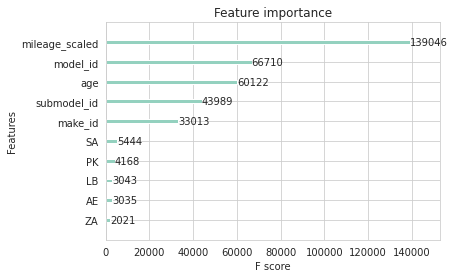

MAE:  0.007345441984205093
MSE:  0.00030948892473788285
RMSE:  0.017592297312684402


In [ ]:
x=XGBRegressor(n_estimators =  200,
        max_depth = 15 ,
        min_child_samples =  5, 
        colsample_bytree = 0.4,
        subsample = 0.3,
        n_jobs = 3 ,
        reg_lambda = 1.5)
model, pred_xgb = fit_pred(x, x_train, y_train,x_test,y_test)
feature_imp(model)
MAE_x, MSE_x, RMSE_x = metrics_calcul(pred_xgb, y_test)

In [ ]:
df_ev = print_res(y_test,pred_xgb)
df_ev.tail(10)

mean of the difference in the test set 0.7325813175041712


,Predicted Price,Actual Price,Residual,Difference%
180475,1.11,1.11,0.00,0.03
180476,1.22,1.25,0.03,2.67
180477,1.15,1.14,-0.01,0.89
180478,1.11,1.10,-0.00,0.39
180479,1.01,1.00,-0.01,0.54
180480,1.13,1.11,-0.01,1.03
180481,1.10,1.10,-0.01,0.66
180482,1.42,1.40,-0.02,1.56
180483,1.11,1.10,-0.01,1.23
180484,1.14,1.12,-0.01,1.15


In [ ]:
#adding the prediction to the test set
test_set = x_test
test_set.insert(9,"prediction",pred_xgb)

We are checking the number of predictions that do not respect the rule from question 2 which we found to be 9458.
We think that a slim difference in price and mileage does not matter too much so we counted the number of cars that have a wide difference and do not respect the rule.
We found 7400 elements that do not respect the new rule that we set which is less than 5% of predictions

In [ ]:
group = test_set.groupby(['make_id','model_id','submodel_id','age'])
count=0
for key, item in group:
    prev_p= 0
    prev_m = 1000000
    line_mileage = group.get_group(key).sort_values('mileage_scaled',ascending=False)
    for price, mile in zip(line_mileage['prediction'],line_mileage['mileage_scaled']):
      if price < prev_p and mile != prev_m :
          count +=1
          prev_p = price
          prev_m = mile
      else:
          prev_p = price
          prev_m = mile
    
print("number of cars that do not respect the rule from question 2 is:",count)  
"""
        price_non_scaled = price * (max_price - min_price) + min_price
        prev_non_scaled = prev_p * (max_price - min_price) + min_price

        mileage_non_scaled = mile * (max_mile - min_mile) + min_mile
        prev_m_non_scaled = prev_m * (max_mile - min_mile) + min_mile
"""
      #print(price, mile)
          


number of cars that do not respect the rule from question 2 is: 9464


'\n        price_non_scaled = price * (max_price - min_price) + min_price\n        prev_non_scaled = prev_p * (max_price - min_price) + min_price\n\n        mileage_non_scaled = mile * (max_mile - min_mile) + min_mile\n        prev_m_non_scaled = prev_m * (max_mile - min_mile) + min_mile\n'

We are checking the number of predictions that do not respect the rule from question 3 which we found to be 58 which represents 0.036% of the test set. This number is negligeable.

In [ ]:
group = test_set.groupby(['make_id','model_id','submodel_id'])
count=0
for key, item in group:
    prev_p= 0
    prev_age = 500
    line_age = group.get_group(key).sort_values('age',ascending=False)
    for price, age in zip(line_age['prediction'],line_mileage['age']):
        
        
        if price < prev_p and prev_age != age :
          count +=1
          prev_p = price
          prev_age = age
        else:
          prev_p = price
          prev_age = age
    
print("number of cars that do not respect the rule from question 3 is:",count)    


number of cars that do not respect the rule from question 3 is: 60


##**Question** 6 : Optional: visuals of price depreciation (price curve for same MMS/MM for different years)


we assumed that price means prediction

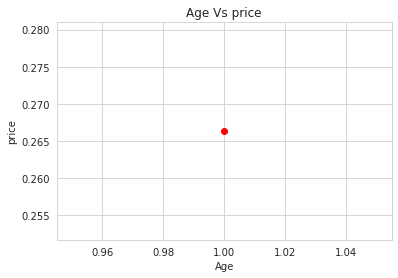

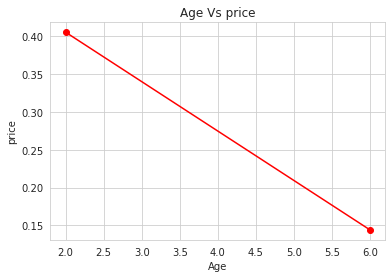

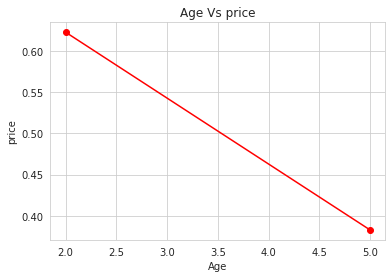

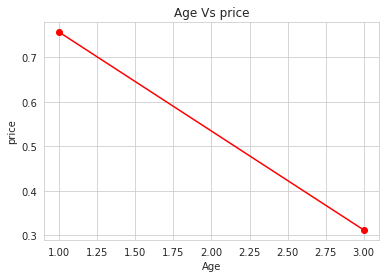

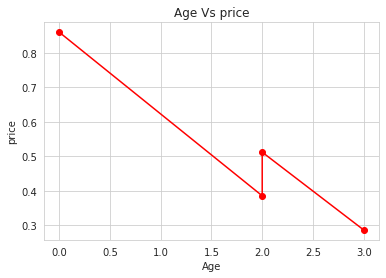

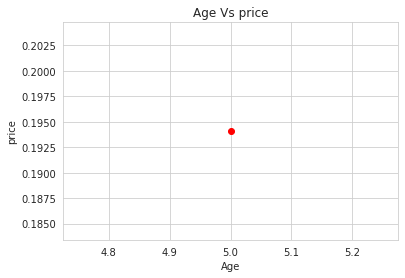

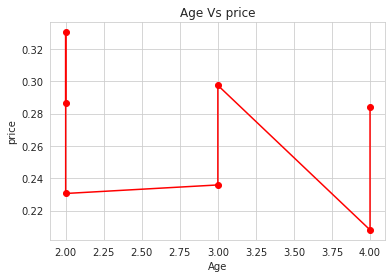

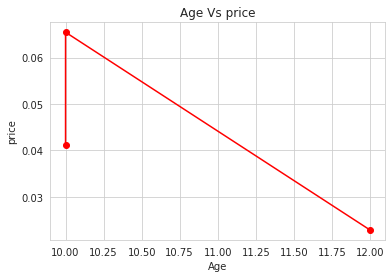

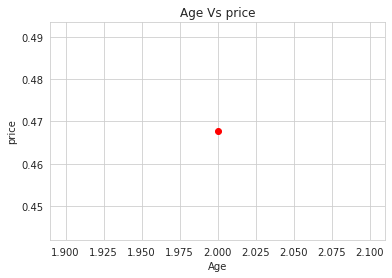

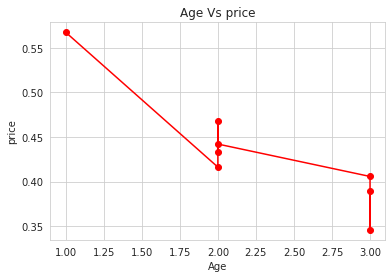

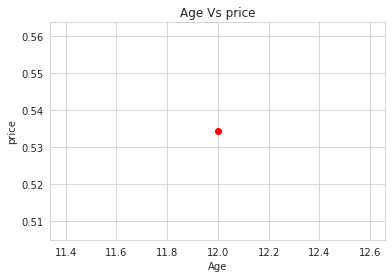

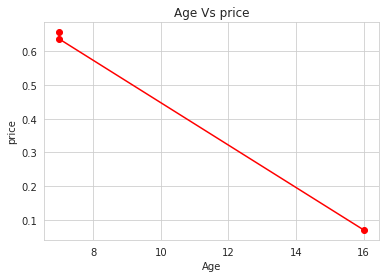

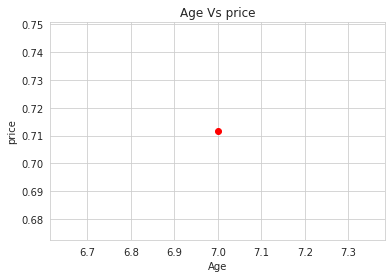

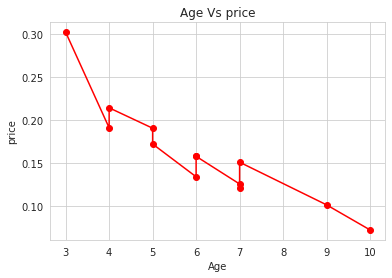

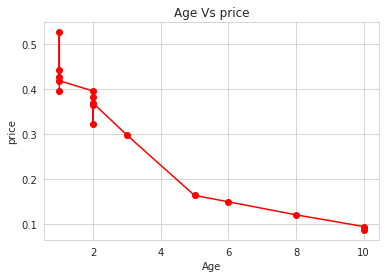

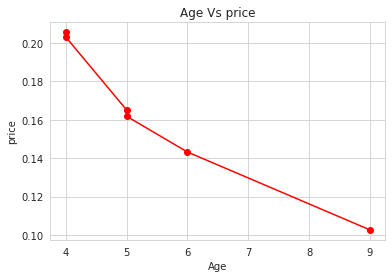

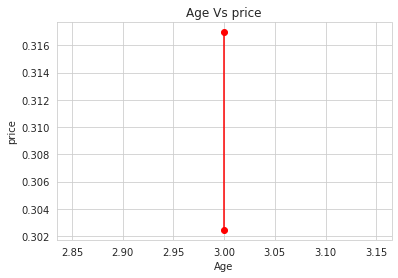

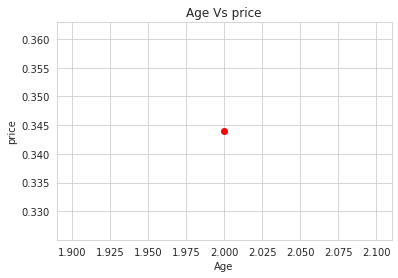

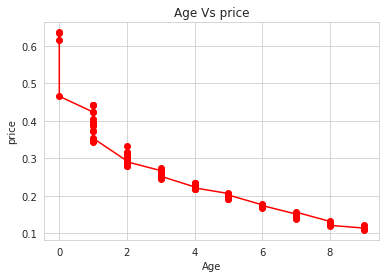

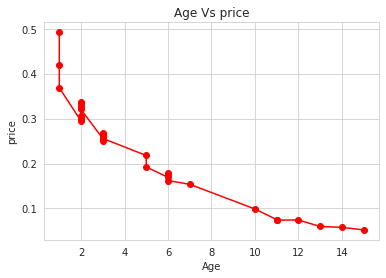

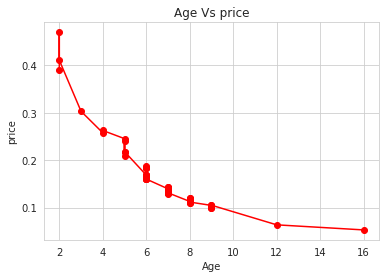

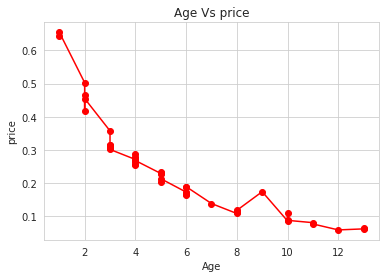

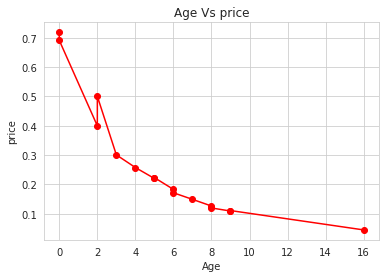

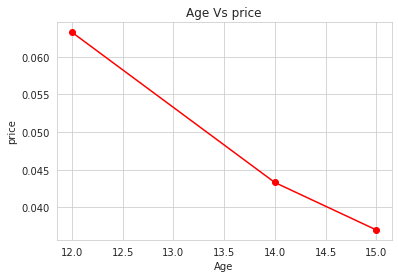

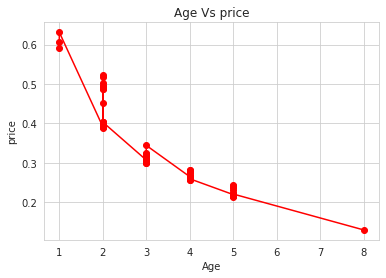

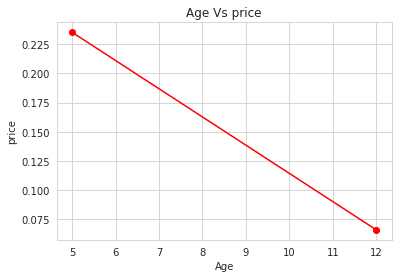

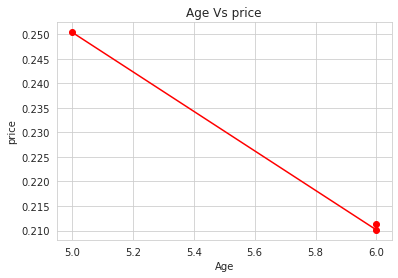

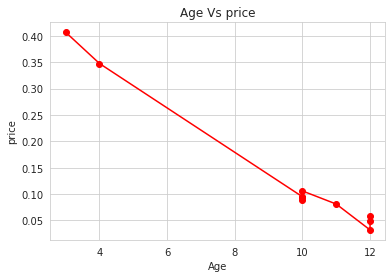

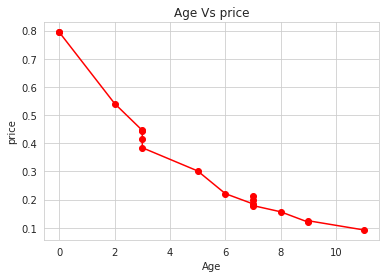

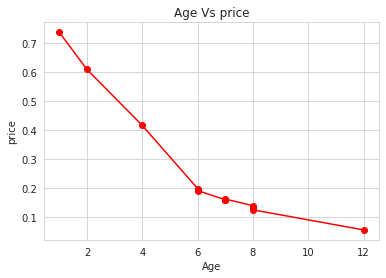

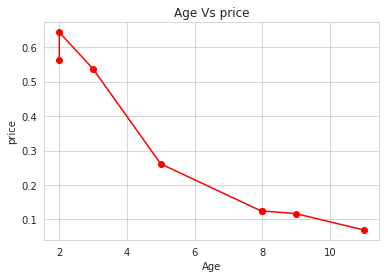

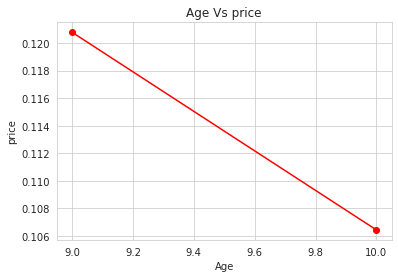

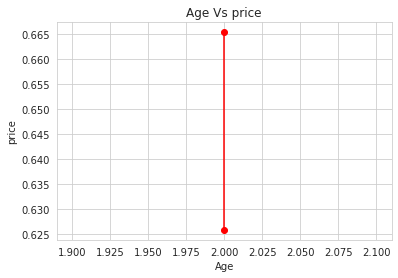

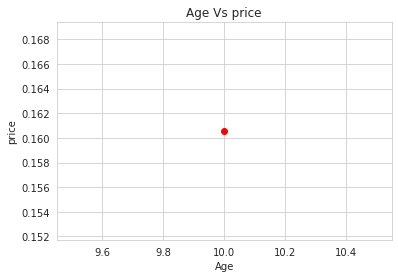

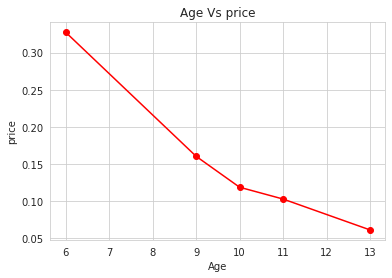

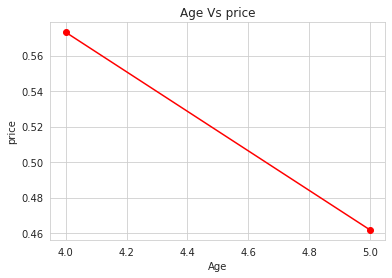

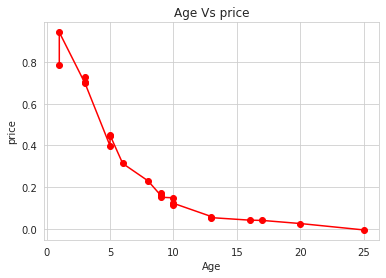

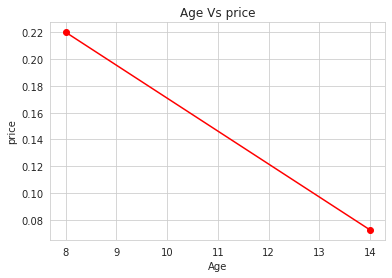

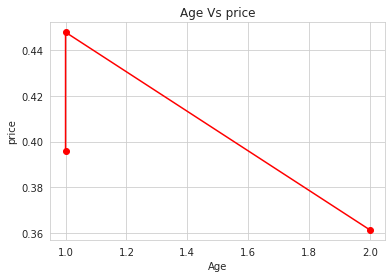

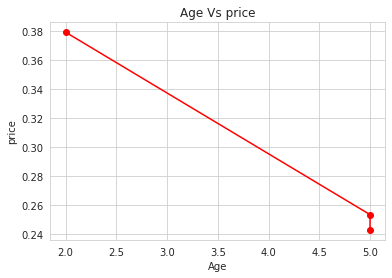

KeyboardInterrupt: ignored

In [ ]:
def plot_age_price(list_age, list_price):
    plt.plot(list_age, list_price,color='red', marker='o')
    plt.title('Age Vs price')
    plt.xlabel('Age')
    plt.ylabel('price')
    plt.grid(True)
    plt.show()

group = test_set.groupby(['make_id','model_id','submodel_id'])
for key, item in group:
    line = group.get_group(key)[['make_id','model_id','submodel_id','age','prediction']].sort_values('age',ascending=False)
    list_age = line['age'].values.tolist()
    list_price = line['prediction'].values.tolist()
    plot_age_price(list_age, list_price)
    

##**Question 4:** How can you enforce monotonicity of year and/or mileage with respect to the price?
We enfored monotonicity on Age which translates to year


In [ ]:
#splitting data
x_train, x_test, y_train, y_test = split_data(final_data, 'price_KWD_scaled')

In [ ]:
x=XGBRegressor(max_depth=15, eta=0.1, subsample=0.7, colsample_bytree=0.8,
        n_estimators = 200, min_child_samples = 3, 
        #colsample_bytree : '0.4',
        n_jobs = 3  ,
        reg_lambda = 1.5,
        num_boost_round = 1000,
        early_stopping_rounds = 10,
        monotone_constraints = (0,0,0,0,-1,0,0,0,0,0,0),
        tree_method = 'hist',
        max_bin = 200)

model_with_constraints = x.fit(x_train,y_train)
model_pred_constrain = model_with_constraints.predict(x_test)
MAE_x, MSE_x, RMSE_x = metrics_calcul(model_pred_constrain, y_test)

[09:58:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE:  0.013999190533091531
MSE:  0.0010216501058614488
RMSE:  0.03196326181511281


In [ ]:
df_ev = print_res(y_test,model_pred_constrain)
df_ev.tail(10)

mean of the difference in the test set 1.398824742957009


,Predicted Price,Actual Price,Residual,Difference%
180475,1.11,1.11,0.00,0.14
180476,1.19,1.25,0.06,4.86
180477,1.17,1.14,-0.03,2.75
180478,1.11,1.10,-0.00,0.35
180479,1.02,1.00,-0.02,2.07
180480,1.12,1.11,-0.00,0.39
180481,1.10,1.10,-0.01,0.55
180482,1.42,1.40,-0.02,1.25
180483,1.08,1.10,0.01,1.31
180484,1.13,1.12,-0.01,0.72


##Question 5: Optional: different model per currency


Since we ended up using the same model, it would be better to run and test within a for loop

--------------------- AED ---------------------
[10:14:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse for trained:  0.005217927879314971
r_squared for trained:  0.5362558302002769


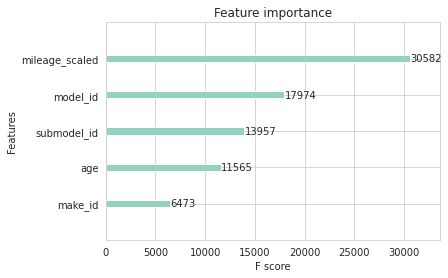

MAE:  0.001889249369527872
MSE:  2.7226771353732437e-05
RMSE:  0.005217927879314971
mean of the difference in the test set 0.18830511906392847
--------------------- KWD ---------------------
[10:14:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse for trained:  0.005217927879314971
r_squared for trained:  0.5362558302002769


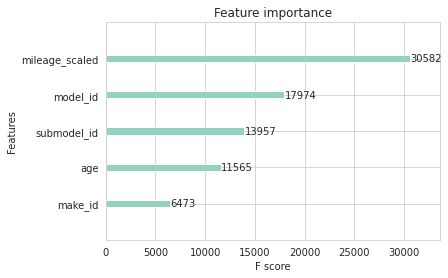

MAE:  0.001889249369527872
MSE:  2.7226771353732437e-05
RMSE:  0.005217927879314971
mean of the difference in the test set 0.18830511906392847
--------------------- LBP ---------------------
[10:14:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse for trained:  0.005217927879314971
r_squared for trained:  0.5362558302002769


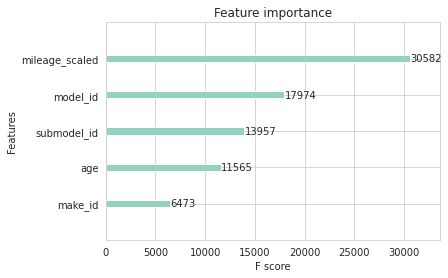

MAE:  0.001889249369527872
MSE:  2.7226771353732437e-05
RMSE:  0.005217927879314971
mean of the difference in the test set 0.18830511906392847
--------------------- PKR ---------------------
[10:15:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse for trained:  0.005217927879314971
r_squared for trained:  0.5362558302002769


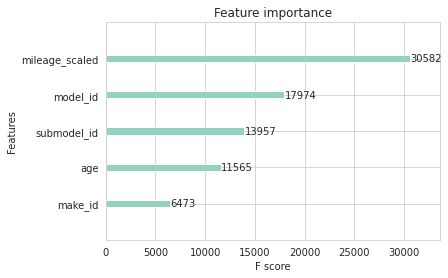

MAE:  0.001889249369527872
MSE:  2.7226771353732437e-05
RMSE:  0.005217927879314971
mean of the difference in the test set 0.18830511906392847
--------------------- SAR ---------------------
[10:15:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse for trained:  0.005217927879314971
r_squared for trained:  0.5362558302002769


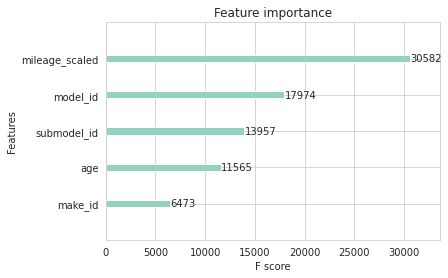

MAE:  0.001889249369527872
MSE:  2.7226771353732437e-05
RMSE:  0.005217927879314971
mean of the difference in the test set 0.18830511906392847
--------------------- ZAR ---------------------
[10:15:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse for trained:  0.005217927879314971
r_squared for trained:  0.5362558302002769


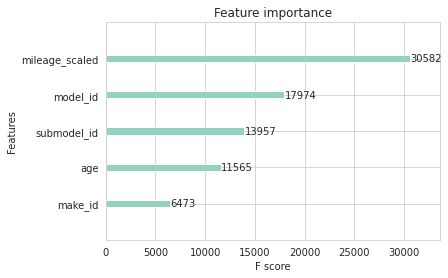

MAE:  0.001889249369527872
MSE:  2.7226771353732437e-05
RMSE:  0.005217927879314971
mean of the difference in the test set 0.18830511906392847


In [ ]:
group = data_currency.groupby(['currency'])
for key, item in group:
  print("---------------------",key,"---------------------")
  data = group.get_group(key).drop('currency',axis=1)
  x_train, x_test, y_train, y_test = split_data(AED_data,'price_scaled')
  pred_xgb_AED, df_ev  = xgboost(x_train, y_train,x_test,y_test) 
  df_ev.tail(10)

##All of the below work was for testing different models

In [ ]:
group = data_currency.groupby(['currency'])
for key, item in group:
  if key == 'AED':
    AED_data = group.get_group(key).drop('currency',axis=1)
  elif key == 'KWD':
    KWD_data = group.get_group(key).drop('currency',axis=1)
  elif key == 'LBP':
    LBP_data = group.get_group(key).drop('currency',axis=1)
  elif key == 'PKR':
    PKR_data = group.get_group(key).drop('currency',axis=1)
  elif key == 'SAR':
    SAR_data = group.get_group(key).drop('currency',axis=1)
  elif key == 'ZAR':
    ZAR_data = group.get_group(key).drop('currency',axis=1)


In [ ]:
def xgboost(x_train, y_train,x_test,y_test):
  x=XGBRegressor(n_estimators =  200,
          max_depth = 15 ,
          min_child_samples =  5, 
          colsample_bytree = 0.4,
          subsample = 0.3,
          n_jobs = 3 ,
          reg_lambda = 1.5)
  model, pred_xgb = fit_pred(x, x_train, y_train,x_test,y_test)
  feature_imp(model)
  MAE_x, MSE_x, RMSE_x = metrics_calcul(pred_xgb, y_test)
  df_ev = print_res(y_test,pred_xgb)
  return pred_xgb, df_ev

####AED

In [ ]:
VIF_check(AED_data.drop(['price_scaled','model_id','submodel_id'],axis=1))

,VIF,Features
0,2.69,make_id
1,5.17,age
2,4.67,mileage_scaled


[10:01:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse for trained:  0.005217927879314971
r_squared for trained:  0.5362558302002769


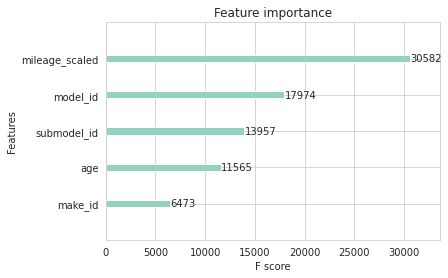

MAE:  0.001889249369527872
MSE:  2.7226771353732437e-05
RMSE:  0.005217927879314971
mean of the difference in the test set 0.18830511906392847


,Predicted Price,Actual Price,Residual,Difference%
25227,1.00,1.00,0.00,0.03
25228,1.00,1.00,0.00,0.00
25229,1.00,1.00,0.00,0.11
25230,1.00,1.00,-0.00,0.02
25231,1.00,1.00,-0.00,0.03
25232,1.01,1.00,-0.01,0.74
25233,1.00,1.00,-0.00,0.21
25234,1.00,1.00,-0.00,0.02
25235,1.00,1.00,0.00,0.08
25236,1.00,1.00,-0.00,0.07


In [ ]:
x_train, x_test, y_train, y_test = split_data(AED_data,'price_scaled')
pred_xgb_AED, df_ev  = xgboost(x_train, y_train,x_test,y_test) 
df_ev.tail(10)

###KWD

In [ ]:
VIF_check(KWD_data.drop(['price_scaled','model_id','submodel_id'],axis=1))

,VIF,Features
0,2.77,make_id
1,3.47,age
2,2.41,mileage_scaled


[10:01:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse for trained:  0.004799862337475552
r_squared for trained:  0.42597346043027995


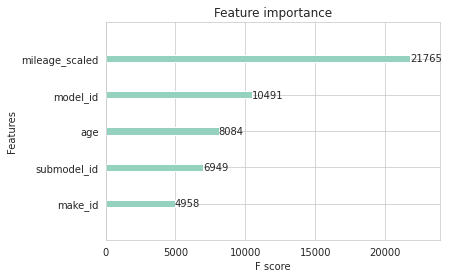

MAE:  0.0018493225544873337
MSE:  2.3038678458716273e-05
RMSE:  0.004799862337475552
mean of the difference in the test set 0.18451600931771836


,Predicted Price,Actual Price,Residual,Difference%
11011,1.00,1.00,0.00,0.01
11012,1.00,1.00,-0.00,0.02
11013,1.00,1.00,-0.00,0.02
11014,1.00,1.00,-0.00,0.01
11015,1.00,1.00,-0.00,0.16
11016,1.00,1.00,0.00,0.01
11017,1.00,1.00,-0.00,0.02
11018,1.00,1.00,-0.00,0.23
11019,1.00,1.00,-0.00,0.02
11020,1.00,1.00,-0.00,0.05


In [ ]:
x_train, x_test, y_train, y_test = split_data(KWD_data,'price_scaled')
pred_xgb_KWD, df_ev  = xgboost(x_train, y_train,x_test,y_test) 
df_ev.tail(10)

###LBP

In [ ]:
VIF_check(LBP_data.drop(['price_scaled','model_id','submodel_id'],axis=1))

,VIF,Features
0,2.64,make_id
1,2.79,age
2,2.35,mileage_scaled


[10:02:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse for trained:  0.002134054359556056
r_squared for trained:  0.2300635263362697


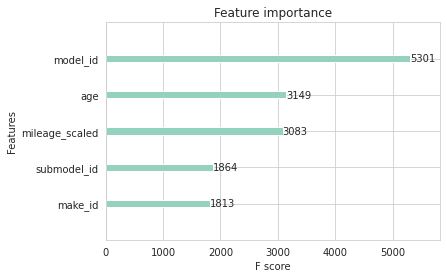

MAE:  0.0007993261583752838
MSE:  4.554188009540208e-06
RMSE:  0.002134054359556056
mean of the difference in the test set 0.07987484194592269


,Predicted Price,Actual Price,Residual,Difference%
3253,1.01,1.00,-0.00,0.40
3254,1.00,1.00,-0.00,0.02
3255,1.00,1.00,-0.00,0.08
3256,1.00,1.00,-0.00,0.06
3257,1.00,1.00,0.00,0.02
3258,1.00,1.00,0.00,0.07
3259,1.00,1.00,0.00,0.01
3260,1.00,1.01,0.00,0.23
3261,1.00,1.00,0.00,0.03
3262,1.00,1.01,0.01,0.61


In [ ]:
x_train, x_test, y_train, y_test = split_data(LBP_data,'price_scaled')
pred_xgb_LBP, df_ev  = xgboost(x_train, y_train,x_test,y_test) 
df_ev.tail(10)

###PKR

In [ ]:
VIF_check(PKR_data.drop(['price_scaled','model_id','submodel_id'],axis=1))

,VIF,Features
0,2.91,make_id
1,3.43,age
2,3.21,mileage_scaled


[10:02:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse for trained:  0.0035574962256084966
r_squared for trained:  0.744812454941665


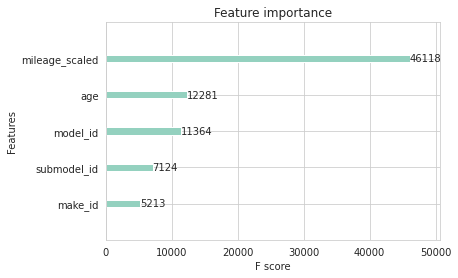

MAE:  0.0017096453013640007
MSE:  1.2655779395218698e-05
RMSE:  0.0035574962256084966
mean of the difference in the test set 0.17104533670368846


,Predicted Price,Actual Price,Residual,Difference%
54296,1.00,1.00,-0.00,0.14
54297,1.01,1.01,-0.00,0.05
54298,1.00,1.01,0.01,0.82
54299,1.00,1.00,0.00,0.05
54300,1.00,1.00,-0.00,0.01
54301,1.00,1.00,0.00,0.01
54302,1.01,1.01,-0.00,0.03
54303,1.00,1.00,-0.00,0.00
54304,1.01,1.01,0.00,0.17
54305,1.02,1.02,-0.00,0.20


In [ ]:
x_train, x_test, y_train, y_test = split_data(PKR_data,'price_scaled')
pred_xgb_PKR, df_ev  = xgboost(x_train, y_train,x_test,y_test) 
df_ev.tail(10)

###SAR

In [ ]:
VIF_check(SAR_data.drop(['price_scaled','model_id','submodel_id'],axis=1))

,VIF,Features
0,1.81,make_id
1,3.07,age
2,2.68,mileage_scaled


[10:02:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse for trained:  0.007447481957249517
r_squared for trained:  0.535668437617848


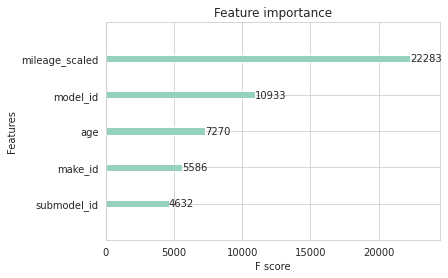

MAE:  0.0027871161692452685
MSE:  5.54649875035571e-05
RMSE:  0.007447481957249517
mean of the difference in the test set 0.2773301488035646


,Predicted Price,Actual Price,Residual,Difference%
7815,1.00,1.00,0.00,0.24
7816,1.00,1.00,-0.00,0.12
7817,1.03,1.04,0.00,0.37
7818,1.00,1.00,0.00,0.02
7819,1.00,1.00,-0.00,0.01
7820,1.00,1.00,0.00,0.18
7821,1.06,1.00,-0.05,5.44
7822,1.00,1.00,-0.00,0.25
7823,1.00,1.00,-0.00,0.07
7824,1.00,1.00,-0.00,0.18


In [ ]:
x_train, x_test, y_train, y_test = split_data(SAR_data,'price_scaled')
pred_xgb_SAR, df_ev  = xgboost(x_train, y_train,x_test,y_test) 
df_ev.tail(10)

###ZAR

[10:02:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse for trained:  0.0035967279526611866
r_squared for trained:  0.5517476207721639


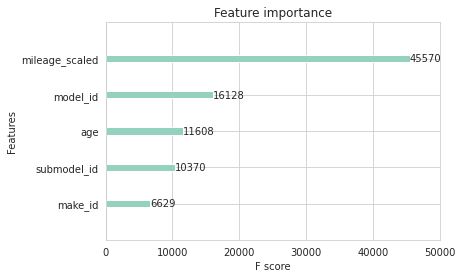

MAE:  0.0011763764015901847
MSE:  1.2936451965454331e-05
RMSE:  0.0035967279526611866
mean of the difference in the test set 0.1174323925767464


,Predicted Price,Actual Price,Residual,Difference%
78826,1.00,1.00,-0.00,0.00
78827,1.00,1.00,0.00,0.00
78828,1.01,1.00,-0.01,0.98
78829,1.00,1.00,-0.00,0.02
78830,1.00,1.00,0.00,0.28
78831,1.00,1.00,-0.00,0.09
78832,1.00,1.00,-0.00,0.01
78833,1.00,1.00,0.00,0.01
78834,1.00,1.00,-0.00,0.15
78835,1.00,1.00,-0.00,0.24


In [ ]:
x_train, x_test, y_train, y_test = split_data(ZAR_data,'price_scaled')
pred_xgb_ZAR, df_ev  = xgboost(x_train, y_train,x_test,y_test) 
df_ev.tail(10)